# ASRR Messy Data Challenge
## Example analysis (Stata version)

In [1]:
# setup
from pathlib import Path
# !python -m pip install stata_setup
# import sys
# sys.path.append(str(Path().absolute().parent))
import stata_setup

STATA_SYSDIR = Path('/Applications/Stata/') 
stata_setup.config(STATA_SYSDIR, 'mp')


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user 2-core network, expiring  9 Sep 2022
Serial number: 501709309029
  Licensed to: Albert Henry
               University College London

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


## Data exploration

### Read in data

In [2]:
%%stata
use ../data/icu_data, clear

### Flag first ICULOS  per patient 

In [3]:
%%stata
sort patid iculos
egen patid_fl = tag(patid)


. sort patid iculos

. egen patid_fl = tag(patid)

. 


### What's in the dataset

In [4]:
%%stata
describe 


Contains data from ../data/icu_data.dta
 Observations:     1,201,974                  
    Variables:            14                  3 Mar 2020 08:58
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
age             float   %9.0g                 Age (years)
gender          byte    %8.0g                 Gender
iculos          int     %8.0g                 ICU length-of-stay (hours since
                                                ICU admission)
hr              double  %10.0g                Heart rate (beats per minute)
temp            double  %10.0g                Temperature (Deg C)
sbp             double  %10.0g                Systolic BP (mm Hg)
dbp             double  %10.0g                Diastolic BP (mm Hg)
resp            double  %10.0g                Respiration ra

### Distributions of each of the variables

In [5]:
%%stata
codebook


-------------------------------------------------------------------------------
age                                                                 Age (years)
-------------------------------------------------------------------------------

                  Type: Numeric (float)

                 Range: [14,100]                      Units: .01
         Unique values: 5,242                     Missing .: 0/1,201,974

                  Mean: 61.7395
             Std. dev.: 16.5491

           Percentiles:     10%       25%       50%       75%       90%
                           38.6        51     63.44        74        82

-------------------------------------------------------------------------------
gender                                                                   Gender
-------------------------------------------------------------------------------

                  Type: Numeric (byte)

                 Range: [0,1]                         Units: 1
         Unique values: 

### Better visualisation of variables

In [6]:
%%stata
inspect


age:  Age (years)                               Number of observations
-----------------                      ---------------------------------------
                                             Total      Integers   Nonintegers
|              #             Negative            -             -             -
|          #   #             Zero                -             -             -
|          #   #             Positive    1,201,974       710,366       491,608
|          #   #                       -----------   -----------   -----------
|      #   #   #             Total       1,201,974       710,366       491,608
|  .   #   #   #   #         Missing             -
+----------------------                -----------
14                  100                  1,201,974
(More than 99 unique values)

gender:  Gender                                 Number of observations
---------------                        ---------------------------------------
                                          

### Complete case indicator

In [7]:
%%stata
egen nvar_miss = rowmiss(o2sat hr temp sbp map resp)
gen cc_fl = (nvar_miss == 0)


. egen nvar_miss = rowmiss(o2sat hr temp sbp map resp)

. gen cc_fl = (nvar_miss == 0)

. 


In [8]:
%%stata
tab cc_fl


      cc_fl |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    865,835       72.03       72.03
          1 |    336,139       27.97      100.00
------------+-----------------------------------
      Total |  1,201,974      100.00


Only 28% of records have no missing vital signs

## Outcome exploration

### How many people were diagnosed with sepsis?

In [9]:
%%stata
tab sepsislabel


SepsisLabel |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |  1,200,317       99.86       99.86
          1 |      1,657        0.14      100.00
------------+-----------------------------------
      Total |  1,201,974      100.00


### When do people get sepsis in ICU?

In [10]:
%%stata
gen time_to_sepsis_temp = iculos if sepsislabel == 1
egen time_to_sepsis = min(time_to_sepsis_temp), by(patid)


. gen time_to_sepsis_temp = iculos if sepsislabel == 1
(1,200,317 missing values generated)

. egen time_to_sepsis = min(time_to_sepsis_temp), by(patid)
(1,093,032 missing values generated)

. 


In [11]:
%%stata
su time_to_sepsis if patid_fl == 1, d


                       time_to_sepsis
-------------------------------------------------------------
      Percentiles      Smallest
 1%            7              7
 5%            9              7
10%           11              7       Obs               1,657
25%           20              7       Sum of wgt.       1,657

50%           45                      Mean           65.74653
                        Largest       Std. dev.      60.86024
75%           91            325
90%          152            327       Variance       3703.968
95%          200            331       Skewness       1.598774
99%          267            331       Kurtosis       5.555945


* min: 7 hours
* max: 331 hours (13.8 days)
* median: 45 hours

(bin=32, start=7, width=10.125)


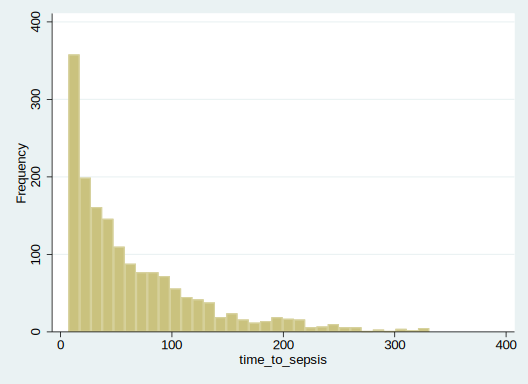

In [12]:
%%stata
hist time_to_sepsis if patid_fl == 1, frequency bin(32) start(7)

### Create indicator for patient who get sepsis:

In [13]:
%%stata
egen any_sepsis = max(sepsislabel), by(patid)

### Drop ICULOS ≥ 6

In [14]:
%%stata
drop if iculos >= 6

(1,047,349 observations deleted)


## Imputing explanatory measures

### Mean Imputation

In [15]:
%%stata
foreach var of varlist o2sat hr temp sbp dbp map resp {

egen `var'_mean = mean(`var') if iculos <= 5, by(patid)
gen `var'_imp1 = `var'
replace `var'_imp1 = `var'_mean if `var'_imp1 ==. & iculos <= 5

}


. foreach var of varlist o2sat hr temp sbp dbp map resp {
  2. 
. egen `var'_mean = mean(`var') if iculos <= 5, by(patid)
  3. gen `var'_imp1 = `var'
  4. replace `var'_imp1 = `var'_mean if `var'_imp1 ==. & iculos <= 5
  5. 
. }
(2,065 missing values generated)
(41,765 missing values generated)
(39,700 real changes made)
(1,310 missing values generated)
(39,034 missing values generated)
(37,724 real changes made)
(27,860 missing values generated)
(113,581 missing values generated)
(85,721 real changes made)
(4,055 missing values generated)
(42,929 missing values generated)
(38,874 real changes made)
(34,855 missing values generated)
(67,216 missing values generated)
(32,361 real changes made)
(3,170 missing values generated)
(41,707 missing values generated)
(38,537 real changes made)
(5,140 missing values generated)
(47,247 missing values generated)
(42,107 real changes made)

. 


### First observation carried backwards

In [16]:
%%stata
foreach var of varlist o2sat hr temp sbp dbp map resp {

gen `var'_imp2 = `var'
by patid (iculos), sort: replace `var'_imp2 = `var'[_n+1] if `var' == .
by patid (iculos), sort: replace `var'_imp2 = `var'[_n+2] if `var' == . & `var'[_n+1] == . 
by patid (iculos), sort: replace `var'_imp2 = `var'[_n+3] if `var' == . & `var'[_n+1] == . & `var'[_n+2] == .
by patid (iculos), sort: replace `var'_imp2 = `var'[_n+4] if `var' == . & `var'[_n+1] == . & `var'[_n+2] == . & `var'[_n+3] == .
}


. foreach var of varlist o2sat hr temp sbp dbp map resp {
  2. 
. gen `var'_imp2 = `var'
  3. by patid (iculos), sort: replace `var'_imp2 = `var'[_n+1] if `var' == .
  4. by patid (iculos), sort: replace `var'_imp2 = `var'[_n+2] if `var' == . & 
> `var'[_n+1] == . 
  5. by patid (iculos), sort: replace `var'_imp2 = `var'[_n+3] if `var' == . & 
> `var'[_n+1] == . & `var'[_n+2] == .
  6. by patid (iculos), sort: replace `var'_imp2 = `var'[_n+4] if `var' == . & 
> `var'[_n+1] == . & `var'[_n+2] == . & `var'[_n+3] == .
  7. }
(41,765 missing values generated)
(32764 real changes made)
(2296 real changes made)
(773 real changes made)
(301 real changes made)
(39,034 missing values generated)
(32558 real changes made)
(1700 real changes made)
(545 real changes made)
(226 real changes made)
(113,581 missing values generated)
(27896 real changes made)
(16913 real changes made)
(10468 real changes made)
(4976 real changes made)
(42,929 missing values generated)
(32398 real changes made)
(2237 r

### Inspect missingness again among imputed variables

In [17]:
%%stata
egen nvar_miss_imp1 = rowmiss(o2sat_imp1 hr_imp1 temp_imp1 sbp_imp1 map_imp1 resp_imp1)
gen cc_fl_imp1 = (nvar_miss_imp1 == 0)


. egen nvar_miss_imp1 = rowmiss(o2sat_imp1 hr_imp1 temp_imp1 sbp_imp1 map_imp1 
> resp_imp1)

. gen cc_fl_imp1 = (nvar_miss_imp1 == 0)

. 


In [18]:
%%stata
tab cc_fl_imp1 if iculos == 1


 cc_fl_imp1 |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      6,897       22.30       22.30
          1 |     24,028       77.70      100.00
------------+-----------------------------------
      Total |     30,925      100.00


In [19]:
%%stata
egen nvar_miss_imp2 = rowmiss(o2sat_imp2 hr_imp2 temp_imp2 sbp_imp2 map_imp2 resp_imp2)
gen cc_fl_imp2 = (nvar_miss_imp2 == 0)


. egen nvar_miss_imp2 = rowmiss(o2sat_imp2 hr_imp2 temp_imp2 sbp_imp2 map_imp2 
> resp_imp2)

. gen cc_fl_imp2 = (nvar_miss_imp2 == 0)

. 


In [20]:
%%stata
tab cc_fl_imp2 if iculos == 1


 cc_fl_imp2 |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      6,897       22.30       22.30
          1 |     24,028       77.70      100.00
------------+-----------------------------------
      Total |     30,925      100.00


78% of rows non-missing for each imputation method

## Modelling

### Dummy indicators for hospital:

In [21]:
%%stata
qui ta hospid, gen(h_)

can use these to include hospital as a fixed-effect (i.e. create intercepts specific each hospital)
We cannot include hospital as a random-effect as there are too few hospitals (n = 2)

### Mean imputation

In [22]:
%%stata
glm any_sepsis age i.gender o2sat_imp1 hr_imp1 temp_imp1 ///
    sbp_imp1 map_imp1 resp_imp1 h_* if iculos == 1, ///
	f(binomial) l(logit) eform nocons 


. glm any_sepsis age i.gender o2sat_imp1 hr_imp1 temp_imp1 ///
>     sbp_imp1 map_imp1 resp_imp1 h_* if iculos == 1, ///
>         f(binomial) l(logit) eform nocons 

Iteration 0:   log likelihood =  -5153.728  
Iteration 1:   log likelihood = -4666.1855  
Iteration 2:   log likelihood = -4660.7151  
Iteration 3:   log likelihood = -4660.7019  
Iteration 4:   log likelihood = -4660.7019  

Generalized linear models                         Number of obs   =     24,028
Optimization     : ML                             Residual df     =     24,018
                                                  Scale parameter =          1
Deviance         =  9321.403872                   (1/df) Deviance =   .3881008
Pearson          =  24067.04487                   (1/df) Pearson  =   1.002042

Variance function: V(u) = u*(1-u)                 [Bernoulli]
Link function    : g(u) = ln(u/(1-u))             [Logit]

                                                  AIC             =   .3887716
Log likeli

#### First observation carried backwards

In [23]:
%%stata
glm any_sepsis age i.gender o2sat_imp2 hr_imp2 temp_imp2 ///
    sbp_imp2 map_imp2 resp_imp2 h_* if iculos == 1, ///
	f(binomial) l(logit) eform nocons


. glm any_sepsis age i.gender o2sat_imp2 hr_imp2 temp_imp2 ///
>     sbp_imp2 map_imp2 resp_imp2 h_* if iculos == 1, ///
>         f(binomial) l(logit) eform nocons

Iteration 0:   log likelihood = -5157.6504  
Iteration 1:   log likelihood = -4675.2941  
Iteration 2:   log likelihood = -4669.9801  
Iteration 3:   log likelihood =  -4669.968  
Iteration 4:   log likelihood =  -4669.968  

Generalized linear models                         Number of obs   =     24,028
Optimization     : ML                             Residual df     =     24,018
                                                  Scale parameter =          1
Deviance         =  9339.936077                   (1/df) Deviance =   .3888723
Pearson          =  23968.24797                   (1/df) Pearson  =   .9979286

Variance function: V(u) = u*(1-u)                 [Bernoulli]
Link function    : g(u) = ln(u/(1-u))             [Logit]

                                                  AIC             =   .3895429
Log likelih

### Higher respiration rate among those with sepsis?

In [24]:
%%stata
bysort any_sepsis: su resp_imp1 if patid_fl == 1


-------------------------------------------------------------------------------
-> any_sepsis = 0

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   resp_imp1 |     28,308    18.18708    4.422866          1         98

-------------------------------------------------------------------------------
-> any_sepsis = 1

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   resp_imp1 |      1,589    19.58373    5.544236          1       44.5



In [25]:
%%stata
bysort any_sepsis: su resp_imp2 if patid_fl == 1


-------------------------------------------------------------------------------
-> any_sepsis = 0

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   resp_imp2 |     28,308    18.17834    5.196284          1         98

-------------------------------------------------------------------------------
-> any_sepsis = 1

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   resp_imp2 |      1,589    19.54751    6.075533          1         50

